In [1]:
%pip install coffea
%pip install --upgrade awkward

  Using cached awkward-1.10.5-cp37-cp37m-macosx_10_9_x86_64.whl (12.0 MB)
  Attempting uninstall: awkward
    Found existing installation: awkward 2.2.4
    Uninstalling awkward-2.2.4:
      Successfully uninstalled awkward-2.2.4
Note: you may need to restart the kernel to use updated packages.
  Using cached awkward-2.2.4-py3-none-any.whl (622 kB)


  Attempting uninstall: awkward
    Found existing installation: awkward 1.10.5
    Uninstalling awkward-1.10.5:
      Successfully uninstalled awkward-1.10.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
coffea 0.7.22 requires awkward<2,>=1.10.3, but you have awkward 2.2.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import itertools
import logging
from pathlib import Path
import numba as nb

import awkward as ak
import click
import h5py as h5
import numpy as np
import vector

from coffea.hist.plot import clopper_pearson_interval
import matplotlib.pyplot as plt

# from src.data.cms.convert_to_h5 import MIN_JETS, N_JETS, N_FJETS

vector.register_awkward()

logging.basicConfig(level=logging.INFO)

/Users/billyli/miniforge_x86_new/envs/phys239/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [13]:
# read test target file
test_file = "//Users/billyli/UCSD/hhh/reports/bv2/hhh_test.h5"
test_h5 = h5.File(test_file)

# read baseline prediction
baseline_file = "//Users/billyli/UCSD/hhh/reports/bv2/pred_baseline.h5"
b_h5 = h5.File(baseline_file)

# read spanet prediction
spanet_file = "//Users/billyli/UCSD/hhh/reports/bv2/dp_on/pred_v53.h5"
s_h5 = h5.File(spanet_file)

In [20]:
s_h5['INPUTS'].keys()

<KeysViewHDF5 ['BoostedJets', 'Jets']>

In [4]:
def sel_pred_by_dp(dps, aps, bb_ps, dp_cut):
    # parse predicted bb assignment by DP
    dp_filter = dps>dp_cut
    ak8_filter = bb_ps>9
    filter = dp_filter&ak8_filter
    
    bb_ps_passed = bb_ps.mask[filter]
    bb_ps_passed = ak.drop_none(bb_ps_passed)
    
    return bb_ps_passed

In [5]:
def sel_target_by_mask(bb_ts, bh_pts, bh_masks):
    bb_ts_selected = bb_ts.mask[bh_masks]
    bb_ts_selected = ak.drop_none(bb_ts_selected)
    
    bh_selected_pts = bh_pts.mask[bh_masks]
    bh_selected_pts = ak.drop_none(bh_selected_pts)
    
    return bb_ts_selected, bh_selected_pts

In [6]:
# A pred look up table is in shape
# [event,
#    pred_H, 
#       [correct, pred_H_pt]]
def gen_pred_LUT(bb_ps_passed, bb_ts_selected, fj_pts):
    LUT = []
    # for each event
    for bb_t_event, bb_p_event, fj_pt_event in zip(bb_ts_selected, bb_ps_passed, fj_pts):
        # for each predicted bb assignment, check if any target H have a same bb assignment
        LUT_event = []
        for i, bb_p in enumerate(bb_p_event):
            correct = 0
            predH_pt = fj_pt_event[bb_p-10]
            for bb_t in bb_t_event:
                if bb_p == bb_t+10:
                    correct = 1
            LUT_event.append([correct, predH_pt])
        LUT.append(LUT_event)
    return LUT

In [7]:
# A target look up table is in shape
# [event,
#    target_H, 
#        target_bb_assign,
#           [retrieved, targetH_pt]]
def gen_target_LUT(bb_ps_passed, bb_ts_selected, targetH_pts):
    LUT = []
    # for each event
    for bb_t_event, bb_p_event, targetH_pts_event in zip(bb_ts_selected, bb_ps_passed, targetH_pts):
        # for each target fatjet, check if the predictions have a p fatject same with the t fatjet
        LUT_event = []
        for i, bb_t in enumerate(bb_t_event):
            retrieved = 0
            targetH_pt = targetH_pts_event[i]
            for bb_p in bb_p_event:
                if bb_p == bb_t+10:
                    retrieved = 1
            LUT_event.append([retrieved, targetH_pt])
        LUT.append(LUT_event)
    return LUT

In [8]:
# generate pred/target LUT
# each entry corresponds to [recoH correct or not, reco H pt]
# or 
# [targetH retrieved or not, target H pt]
def parse_boosted_w_target(testfile, predfile, dp_cut=0.5):
    # Collect H pt, mask, target and predicted jet and fjets for 3 Hs in each event
    # h pt
    bh1_pt = np.array(testfile['TARGETS']['bh1']['pt'])
    bh2_pt = np.array(testfile['TARGETS']['bh2']['pt'])
    bh3_pt = np.array(testfile['TARGETS']['bh3']['pt'])

    # mask
    bh1_mask = np.array(testfile['TARGETS']['bh1']['mask'])
    bh2_mask = np.array(testfile['TARGETS']['bh2']['mask'])
    bh3_mask = np.array(testfile['TARGETS']['bh3']['mask'])

    # target assignment
    bb_bh1_t = np.array(testfile["TARGETS"]["bh1"]['bb'])
    bb_bh2_t = np.array(testfile["TARGETS"]["bh2"]['bb'])
    bb_bh3_t = np.array(testfile["TARGETS"]["bh3"]['bb'])

    # pred assignment
    bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])
    bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])
    bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])


    # boosted Higgs detection probability
    dp_bh1 = np.array(predfile["TARGETS"]["bh1"]['detection_probability'])
    dp_bh2 = np.array(predfile["TARGETS"]["bh2"]['detection_probability'])
    dp_bh3 = np.array(predfile["TARGETS"]["bh3"]['detection_probability'])
    
    # fatjet assignment probability
    ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['assignment_probability'])
    ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['assignment_probability'])
    ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['assignment_probability'])
    
    # collect fatjet pt
    fj_pts = np.array(testfile['INPUTS']['BoostedJets']['fj_pt'])
    
    # convert some arrays to ak array
    dps = np.concatenate((dp_bh1.reshape(-1, 1), dp_bh2.reshape(-1, 1), dp_bh3.reshape(-1, 1)), axis=1)
    dps = ak.Array(dps)
    aps = np.concatenate((ap_bh1.reshape(-1, 1), ap_bh2.reshape(-1, 1), ap_bh3.reshape(-1, 1)), axis=1)
    aps = ak.Array(aps)
    bb_ps = np.concatenate((bb_bh1_p.reshape(-1, 1), bb_bh2_p.reshape(-1, 1), bb_bh3_p.reshape(-1, 1)), axis=1)
    bb_ps = ak.Array(bb_ps)
    bb_ts = np.concatenate((bb_bh1_t.reshape(-1, 1), bb_bh2_t.reshape(-1, 1), bb_bh3_t.reshape(-1, 1)), axis=1)
    bb_ts = ak.Array(bb_ts)
    fj_pts = ak.Array(fj_pts)
    bh_masks = np.concatenate((bh1_mask.reshape(-1, 1), bh2_mask.reshape(-1, 1), bh3_mask.reshape(-1, 1)), axis=1)
    bh_masks = ak.Array(bh_masks)
    bh_pts = np.concatenate((bh1_pt.reshape(-1, 1), bh2_pt.reshape(-1, 1), bh3_pt.reshape(-1, 1)), axis=1)
    bh_pts = ak.Array(bh_pts)
    
    # select predictions and targets
    bb_ts_selected, targetH_selected_pts = sel_target_by_mask(bb_ts, bh_pts, bh_masks)
    bb_ps_selected = sel_pred_by_dp(dps, aps, bb_ps, dp_cut)
    
    # generate correct/retrieved LUT for pred/target respectively
    LUT_pred = gen_pred_LUT(bb_ps_selected, bb_ts_selected, fj_pts)
    LUT_target = gen_target_LUT(bb_ps_selected, bb_ts_selected, targetH_selected_pts)
    
    return LUT_pred, LUT_target

In [ ]:
def sel_pred_h_by_dp(dps, aps, b1_ps, b2_ps, dp_cut=0.8, ap_cut=1/13):
    # parse predicted bb assignment by DP
    dp_filter = dps > dp_cut
    b1_ak4_filter = b1_ps<10
    b2_ak4_filter = b2_ps<10
    filter = dp_filter & b1_ak4_filter & b2_ak4_filter
    
    b1_ps_passed = b1_ps.mask[filter]
    b1_ps_passed = ak.drop_none(b1_ps_passed)
    
    b2_ps_passed = b2_ps.mask[filter]
    b2_ps_passed = ak.drop_none(b2_ps_passed)
    
    return b1_ps_passed, b2_ps_passed

In [ ]:
def sel_target_h_by_mask(bb_ts, bh_pts, h_masks):
    bb_ts_selected = bb_ts.mask[h_masks]
    bb_ts_selected = ak.drop_none(bb_ts_selected)
    
    bh_selected_pts = bh_pts.mask[bh_masks]
    bh_selected_pts = ak.drop_none(bh_selected_pts)
    
    return bb_ts_selected, bh_selected_pts

In [ ]:
def parse_resolved_w_target(testfile, predfile, dp_cut=0.5):
    # h pt
    h1_pt = np.array(testfile['TARGETS']['h1']['pt'])
    h2_pt = np.array(testfile['TARGETS']['h2']['pt'])
    h3_pt = np.array(testfile['TARGETS']['h3']['pt'])
    
    # mask
    h1_mask = np.array(testfile['TARGETS']['h1']['mask'])
    h2_mask = np.array(testfile['TARGETS']['h2']['mask'])
    h3_mask = np.array(testfile['TARGETS']['h3']['mask'])
    
    # target assignments
    b1_h1_t = np.array(testfile["TARGETS"]["h1"]['b1'])
    b1_h2_t = np.array(testfile["TARGETS"]["h2"]['b1'])
    b1_h3_t = np.array(testfile["TARGETS"]["h3"]['b1'])

    b2_h1_t = np.array(testfile["TARGETS"]["h1"]['b2'])
    b2_h2_t = np.array(testfile["TARGETS"]["h2"]['b2'])
    b2_h3_t = np.array(testfile["TARGETS"]["h3"]['b2'])
    
    # predict assignments
    b1_h1_p = np.array(predfile["TARGETS"]["h1"]['b1'])
    b1_h2_p = np.array(predfile["TARGETS"]["h2"]['b1'])
    b1_h3_p = np.array(predfile["TARGETS"]["h3"]['b1'])

    b2_h1_p = np.array(predfile["TARGETS"]["h1"]['b2'])
    b2_h2_p = np.array(predfile["TARGETS"]["h2"]['b2'])
    b2_h3_p = np.array(predfile["TARGETS"]["h3"]['b2'])
    
    # resolved Higgs detection probability
    dp_h1 = np.array(predfile["TARGETS"]["h1"]['detection_probability'])
    dp_h2 = np.array(predfile["TARGETS"]["h2"]['detection_probability'])
    dp_h3 = np.array(predfile["TARGETS"]["h3"]['detection_probability'])
    
    # ak4 jets assignment probability
    ap_h1 = np.array(predfile["TARGETS"]["h1"]['assignment_probability'])
    ap_h2 = np.array(predfile["TARGETS"]["h2"]['assignment_probability'])
    ap_h3 = np.array(predfile["TARGETS"]["h3"]['assignment_probability'])
    
    # reconstruct jet 4-momentum objects
    j_pts = np.array(testfile['INPUTS']['Jets']['pt'])
    
    # convert some numpy arrays to ak arrays
    dps = np.concatenate((dp_h1.reshape(-1, 1), dp_h2.reshape(-1, 1), dp_h3.reshape(-1, 1)), axis=1)
    dps = ak.Array(dps)
    aps = np.concatenate((ap_h1.reshape(-1, 1), ap_h2.reshape(-1, 1), ap_h3.reshape(-1, 1)), axis=1)
    aps = ak.Array(aps)
    b1_ps = np.concatenate((b1_bh1_p.reshape(-1, 1), b1_bh2_p.reshape(-1, 1), b1_bh3_p.reshape(-1, 1)), axis=1)
    b1_ps = ak.Array(b1_ps)
    b1_ts = np.concatenate((b1_bh1_t.reshape(-1, 1), b1_bh2_t.reshape(-1, 1), b1_bh3_t.reshape(-1, 1)), axis=1)
    b1_ts = ak.Array(b1_ts)
    b2_ps = np.concatenate((b2_bh1_p.reshape(-1, 1), b2_bh2_p.reshape(-1, 1), b2_bh3_p.reshape(-1, 1)), axis=1)
    b2_ps = ak.Array(b2_ps)
    b2_ts = np.concatenate((b2_bh1_t.reshape(-1, 1), b2_bh2_t.reshape(-1, 1), b2_bh3_t.reshape(-1, 1)), axis=1)
    b2_ts = ak.Array(b2_ts)
    j_pts = ak.Array(j_pts)
    h_masks = np.concatenate((h1_mask.reshape(-1, 1), h2_mask.reshape(-1, 1), h3_mask.reshape(-1, 1)), axis=1)
    h_masks = ak.Array(h_masks)
    
    # con
    h_pts = np.concatenate((bh1_pt.reshape(-1, 1), bh2_pt.reshape(-1, 1), bh3_pt.reshape(-1, 1)), axis=1)
    h_pts = ak.Array(bh_pts)
    
    # select predictions and targets
    bb_ts_selected, targetH_selected_pts = sel_target_by_mask(bb_ts, bh_pts, bh_masks)
    b1_ps_selected, b2_ps_selected = sel_pred_h_by_dp(dps, aps, b1_ps, b2_ps, dp_cut=0.8, ap_cut=1/13)
    
    return

In [9]:
# calculate efficiency
# if bins=None, put all data in a single bin
def calc_eff(LUT_pred, bins):
    predHs = [predH for event in LUT_pred for predH in event]
    predHs = np.array(predHs)
    
    predHs_inds = np.digitize(predHs[:,1], bins)
    
    correctTruth_per_bin = []
    for bin_i in range(1, len(bins)):
        correctTruth_per_bin.append(predHs[:,0][predHs_inds==bin_i])
    correctTruth_per_bin = ak.Array(correctTruth_per_bin)
    
    means = ak.mean(correctTruth_per_bin, axis=-1)
    
    errs = np.abs(
    clopper_pearson_interval(num=ak.sum(correctTruth_per_bin, axis=-1),\
                             denom=ak.num(correctTruth_per_bin, axis=-1)) - means
    )
    
    return means, errs

In [10]:
# calculate purity
def calc_pur(LUT_target, bins):
    targetHs = [targetH for event in LUT_target for targetH in event]
    targetHs = np.array(targetHs)
    
    targetHs_inds = np.digitize(targetHs[:,1], bins)
    
    correctTruth_per_bin = []
    for bin_i in range(1, len(bins)):
        correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
    correctTruth_per_bin = ak.Array(correctTruth_per_bin)
    
    means = ak.mean(correctTruth_per_bin, axis=-1)
    
    errs = np.abs(
    clopper_pearson_interval(num=ak.sum(correctTruth_per_bin, axis=-1),\
                             denom=ak.num(correctTruth_per_bin, axis=-1)) - means
    )
    
    return means, errs

In [11]:
bins = np.arange(200, 1000, 100)
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(bins.size-1)]
xerr=(bins[1]-bins[0])/2*np.ones(bins.shape[0]-1)

[Text(0.5, 0, 'Gen H pT (GeV)'),
 Text(0, 0.5, 'Matching purity'),
 Text(0.5, 1.0, 'Matching Purity vs. Gen H pT, DP cut at 0.8, AP cut at 1/13')]

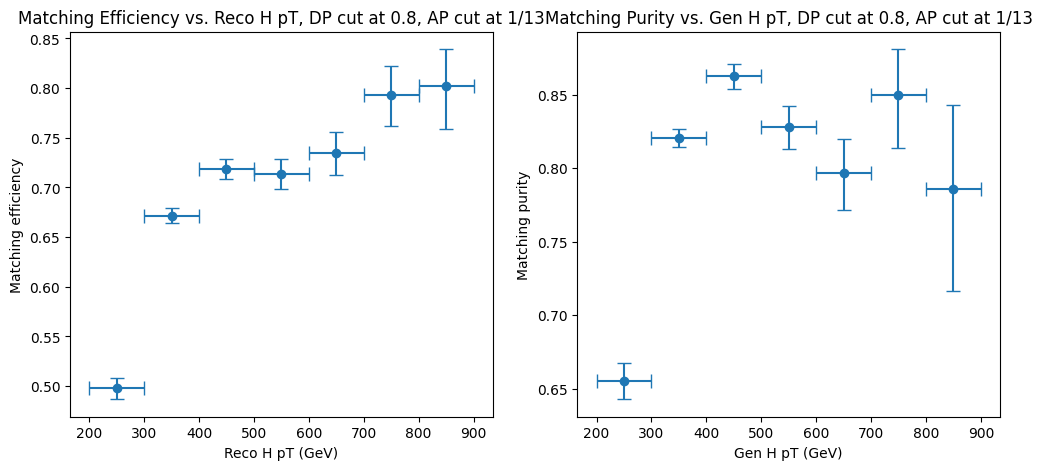

In [12]:
dp_cut = 0.8
LUT_pred_spanet, LUT_target_spanet = parse_pred_w_target(test_h5, s_h5, dp_cut=dp_cut)
eff_s, efferr_s = calc_eff(LUT_pred_spanet, bins)
pur_s, purerr_s = calc_pur(LUT_target_spanet, bins)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].errorbar(x=bin_centers, y=eff_s, xerr=xerr, yerr=efferr_s, fmt='o', capsize=5, label='Trust if a fatjet is assigned')
ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"Matching Efficiency vs. Reco H pT, DP cut at {dp_cut}, AP cut at 1/13")

ax[1].errorbar(x=bin_centers, y=pur_s, xerr=xerr, yerr=purerr_s, fmt='o', capsize=5, label='Trust if a fatjet is assigned')
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"Matching Purity vs. Gen H pT, DP cut at {dp_cut}, AP cut at 1/13")